In [1]:
import keras
import tensorflow as tf

from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2 as cv
import datetime
import shutil

2025-01-04 02:52:12.012123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-04 02:52:12.028203: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-04 02:52:12.032876: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 02:52:12.044595: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-04 02:52:12.779316: W tensorflow/compiler/tf2

In [2]:
"""Hyperparameters"""

DATASET_NAME = "flow_large"
FOLDER_NAME = "all_exp/exp3"
CHECKPOINT_PATH = "checkpoints"

SEED = 42

# archictecture
IMAGE_SIZE = (192, 592)
LATENT_DIM = 512
DISC_CONV_WIDTHS = [32, 64, 128, 256]
CONV_WIDTHS = [32, 64, 128, 256, 516]
KERNELS = [3, 3, 3, 3]
CONV_DEPTH = 2

# optimization
LEARNING_RATE = 5e-5
WEIGHT_DECAY = LEARNING_RATE/10
BATCH_SIZE = 4
EPOCH = 100

# callbacks
CHECKPOINT_PATH = "checkpoints"
PATIENCE = 25
START_FROM_EPOCH = 50
GENERATED_IMAGE_PATH = "generated_images"

# modes 
MODE = "training"
LOAD_WEIGTHS = True
LOAD_WEIGHT_PATH = ""
IMAGES_TO_SAVE = 5

In [3]:
"""Helper Functions"""

def load_dataset(): 
    # Load local dataset as tensorflow dataset object
    cwd = os.getcwd()
    img_dir = os.path.join(cwd, DATASET_NAME)
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        img_dir, 
        validation_split = None,
        subset=None, 
        seed = SEED,
        image_size = (IMAGE_SIZE[0], IMAGE_SIZE[1]),  
        batch_size = None,
        shuffle = True,
        crop_to_aspect_ratio = True,
        pad_to_aspect_ratio = False,
    )
    return train_ds

def normalize_image(images, _):    
    # Clip pixel values to the range [0, 1]
    return tf.clip_by_value(images / 255, 0.0, 1.0)

def prepare_dataset(train_ds): 
    # Use in combination with load_dataset()
    train_ds = (train_ds
                .map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE) # each dataset has the structure
                .cache()                                                   # (image, labels) when inputting to                                 # map
                .shuffle(10 * BATCH_SIZE, seed=SEED)
                .batch(BATCH_SIZE, drop_remainder=True)
                .prefetch(buffer_size=tf.data.AUTOTUNE))
    return train_ds


In [4]:
def CreateDir(folder_name):
   if not os.path.exists(folder_name):
       os.makedirs(folder_name)   

In [5]:
dataset = load_dataset()
dataset = prepare_dataset(dataset)

Found 597 files belonging to 1 classes.


I0000 00:00:1735977141.977432   21277 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735977142.025968   21277 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735977142.026184   21277 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735977142.027053   21277 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

2025-01-04 02:52:24.439232: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


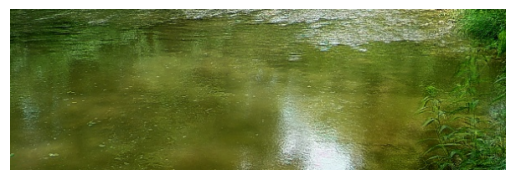

In [6]:

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


In [7]:
def identity(x): 
    return x

def Build_Discriminator(): 
    discriminator_input = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Conv2D(DISC_CONV_WIDTHS[0], KERNELS[0], strides=2, padding="same", kernel_initializer='he_normal')(discriminator_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    for i in range(1, len(DISC_CONV_WIDTHS)-1): 
        x = layers.Conv2D(DISC_CONV_WIDTHS[i], KERNELS[i], strides=2, padding="same", kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)
        if CONV_DEPTH > 0: 
            for _ in range(CONV_DEPTH): 
                x = layers.Conv2D(DISC_CONV_WIDTHS[i], KERNELS[i], strides=1, padding="same", kernel_initializer='he_normal')(x)
                x = layers.BatchNormalization()(x)
                x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Lambda(identity, name="final_output")(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)
    discriminator_output = layers.Dense(1, activation="sigmoid")(x)
    """SOMETIMES LEAVING THE ACTIVATION UNBOUNDED CAN YIELD EFFECTIVENESS"""
    return keras.Model(discriminator_input, discriminator_output, name="discriminator")

discriminator = Build_Discriminator()
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 192, 592, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 296, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 296, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 96, 296, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 148, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 148, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 48, 148, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 148, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 148, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 48, 148, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 148, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 148, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 48, 148, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 74, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 24, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 74, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 24, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 74, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 692,033 (2.64 MB)

 Trainable params: 690,817 (2.64 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [18]:
# def Build_Generator():
#     latent_inputs = keras.Input(shape=(LATENT_DIM,))
    
#     # Calculate initial dimensions for proper upscaling
#     init_height = IMAGE_SIZE[0] // (2 ** len(CONV_WIDTHS))
#     init_width = IMAGE_SIZE[1] // (2 ** len(CONV_WIDTHS))
#     print(init_height, init_width)
    
#     # Initial dense layer with correct sizing
#     x = layers.Dense(init_height * init_width * CONV_WIDTHS[-1], kernel_initializer='he_normal')(latent_inputs)
#     x = layers.LeakyReLU(negative_slope=0.2)(x)
#     x = layers.Reshape((init_height, init_width, CONV_WIDTHS[-1]))(x)
    
#     # Upsampling blocks
#     for i in range(len(CONV_WIDTHS)-1, -1, -1):
#         # Main transposed convolution
#         x = layers.Conv2DTranspose(CONV_WIDTHS[i], KERNELS[i], strides=2, padding="same", kernel_initializer='he_normal')(x)
#         x = layers.BatchNormalization(momentum=0.8)(x)
#         x = layers.LeakyReLU(negative_slope=0.2)(x)
        
#         # Additional depth layers
#         for _ in range(CONV_DEPTH):
#             x = layers.Conv2DTranspose(
#                 CONV_WIDTHS[i], KERNELS[i], strides=1, padding="same", kernel_initializer='he_normal')(x)
#             x = layers.BatchNormalization(momentum=0.8)(x)
#             x = layers.LeakyReLU(negative_slope=0.2)(x)
    
#     # Final output layer
#     generator_outputs = layers.Conv2DTranspose(3, kernel_size=5, padding="same",activation="tanh", kernel_initializer='he_normal')(x)
#     return keras.Model(latent_inputs, generator_outputs, name="generator")

# generator = Build_Generator()
#generator.summary()

In [8]:
final_output_shape = discriminator.get_layer("final_output").output.shape[1:]

print(final_output_shape)

def Build_Generator():
    latent_inputs = keras.Input(shape=(final_output_shape[0], final_output_shape[0], LATENT_DIM))
    x = layers.Conv2DTranspose(LATENT_DIM, KERNELS[i], strides=1, padding="same", kernel_initializer='he_normal')(latent_inputs)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Reshape(final_output_shape)(x)
    for i in range(len(CONV_WIDTHS)-1, -1, -1): 
        x = layers.Conv2DTranspose(CONV_WIDTHS[i], KERNELS[i], strides=2, padding="same", kernel_initializer='he_normal')(x) 
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)
        if CONV_DEPTH > 0:
            for _ in range(CONV_DEPTH):
                x = layers.Conv2DTranspose(CONV_WIDTHS[i], KERNELS[i], strides=1, padding="same", kernel_initializer='he_normal')(x)
                x = layers.BatchNormalization()(x)
                x = layers.LeakyReLU(negative_slope=0.2)(x)
    generator_outputs = layers.Conv2DTranspose(3, kernel_size=5, activation="sigmoid", padding="same", kernel_initializer='he_normal')(x)
    return keras.Model(latent_inputs, generator_outputs, name="generator")

generator = Build_Generator()
generator.summary()

(12, 37, 516)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 229104)         │   117,530,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 229104)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 12, 37, 516)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 24, 74, 516)    │     2,396,820 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 24, 74, 516)    │         2,064 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 24, 74, 516)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 24, 74, 516)    │     2,396,820 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 24, 74, 516)    │         2,064 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 24, 74, 516)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 24, 74, 516)    │     2,396,820 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 24, 74, 516)    │         2,064 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 24, 74, 516)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 48, 148, 256)   │     1,189,120 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 48, 148, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 48, 148, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 48, 148, 256)   │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 48, 148, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 48, 148, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 48, 148, 256)   │       590,08

 Total params: 127,844,319 (487.69 MB)

 Trainable params: 127,838,535 (487.67 MB)

 Non-trainable params: 5,784 (22.59 KB)

In [9]:
class GAN(keras.Model):
    def __init__(self):
        super().__init__()
        self.discriminator = Build_Discriminator()
        self.generator = Build_Generator()
        self.latent_dim = LATENT_DIM
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def generate(self, num_of_images, generated_images_dir): 
        current_time = datetime.datetime.now()
        formatted_time = current_time.strftime("%Y-%m-%d_%H:%M:%S")
        random_latent_vectors = keras.random.normal(
            shape=(num_of_images, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(num_of_images):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"{generated_images_dir}/generated_img_{formatted_time}%d.png" % i)

    def train_step(self, real_images, n_generator_steps=3):
        batch_size = ops.shape(real_images)[0]
        
        # Train discriminator (once)
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=SEED
        )
        generated_images = self.generator(random_latent_vectors)
        combined_images = ops.concatenate([generated_images, real_images], axis=0)
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        
        # Train generator (multiple times)
        g_loss = 0
        for _ in range(n_generator_steps):
            random_latent_vectors = keras.random.normal(
                shape=(batch_size, self.latent_dim), 
                seed=self.seed_generator
            )
            misleading_labels = ops.zeros((batch_size, 1))
            
            with tf.GradientTape() as tape:
                predictions = self.discriminator(self.generator(random_latent_vectors))
                step_g_loss = self.loss_fn(misleading_labels, predictions)
            grads = tape.gradient(step_g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(
                zip(grads, self.generator.trainable_weights)
            )
            g_loss += step_g_loss
        
        # Average the generator loss over all steps
        g_loss = g_loss / n_generator_steps
        
        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [10]:
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d_%H:%M:%S")

csv_dir = os.path.join(FOLDER_NAME, "csv_files")
CreateDir(csv_dir)

checkpoint_dir = os.path.join(FOLDER_NAME, CHECKPOINT_PATH)
CreateDir(checkpoint_dir)

generated_images_dir = os.path.join(FOLDER_NAME, "generated_images")
CreateDir(generated_images_dir)

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=IMAGES_TO_SAVE, latent_dim=LATENT_DIM):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch, logs=None):
    # def on_train_end(self, logs=None):
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            # CHANGED FROM FORMATTED TIME TO EPOCH
            img.save(f"{generated_images_dir}/generated_img_{epoch}%d.png" % i)

# create a callback for logging csv files
csv_callback = keras.callbacks.CSVLogger(filename=f"{csv_dir}/log_{formatted_time}.csv", separator=",", append=True)

# Create a callback that saves the models' weights
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=f"{checkpoint_dir}/best.weights.h5",
                                                        save_best_only=True, 
                                                        save_weights_only=True, 
                                                        monitor="g_loss",
                                                        verbose=1,
                                                        mode="min")

# Create an early stopping callback
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="g_loss", 
                                                        min_delta=LEARNING_RATE/10, 
                                                        mode="min",
                                                        patience=PATIENCE, 
                                                        verbose=1, 
                                                        restore_best_weights=True, 
                                                        start_from_epoch=START_FROM_EPOCH)


In [48]:
epochs = EPOCH  # In practice, use ~100 epochs
learning_rate = LEARNING_RATE

gan = GAN()
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=learning_rate/2),
    g_optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=2, latent_dim=LATENT_DIM), 
                                       csv_callback, 
                                       #checkpoint_callback, 
                                       early_stopping_callback])

gan.save_weights(f"{checkpoint_dir}/last.weights.weights.h5")

Epoch 1/5
 1/74 ━━━━━━━━━━━━━━━━━━━━ 14:18 12s/step - d_loss: 0.6936 - g_loss: 0.6860

2025-01-03 15:53:29.578152: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_7', 96 bytes spill stores, 96 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_9', 96 bytes spill stores, 96 bytes spill loads



74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - d_loss: 0.7230 - g_loss: 0.6651
Epoch 1: g_loss improved from inf to 0.64928, saving model to all_exp/exp1/checkpoints/best.weights_2025-01-03_15:53:17.weights.h5
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - d_loss: 0.7235 - g_loss: 0.6649
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - d_loss: 1.2747 - g_loss: 0.7375
Epoch 2: g_loss did not improve from 0.64928
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - d_loss: 1.2767 - g_loss: 0.7376
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - d_loss: 1.6001 - g_loss: 0.8271
Epoch 3: g_loss did not improve from 0.64928
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - d_loss: 1.6015 - g_loss: 0.8307
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - d_loss: 1.1578 - g_loss: 1.4509
Epoch 4: g_loss did not improve from 0.64928
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - d_loss: 1.1584 - g_loss: 1.4486
Epoch 5/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - d_loss: 1.0283 - g_loss: 0.8716
Epoch 5: g_loss di

In [11]:
print(checkpoint_dir)

gan = GAN()
gan.load_weights(f"{checkpoint_dir}/best.weights.h5")
gan.generate(5, generated_images_dir)

all_exp/exp2/checkpoints


2025-01-03 18:38:04.151859: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1735947484.218524   18726 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1735947484.236240   18726 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1735947484.276410   18726 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1735947484.277756   18726 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1735947484.279128   18726 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1735947484.280506   18726 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1735947484.282526   18726 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1735947484.284490   18726 gpu_t